In [1]:
import os
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2

print("PyTorch version:", torch.__version__)
print("CUDA is available:", torch.cuda.is_available())



PyTorch version: 2.7.1+cu126
CUDA is available: True


In [2]:
# !pip install torch-tensorrt

In [3]:
# !pip uninstall torchvision
# !pip install torchvision --no-cache-dir --force-reinstall

In [4]:
import os
os.environ["PYTORCH_JIT_LOG_LEVEL"] = ">>graph_executor,>>codegen,>>aliasdb"

In [5]:
torch._C._jit_set_profiling_executor(True)
torch._C._jit_set_profiling_mode(True)

True

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch_tensorrt
from typing import Optional, Tuple, Type

Unable to import quantization op. Please install modelopt library (https://github.com/NVIDIA/TensorRT-Model-Optimizer?tab=readme-ov-file#installation) to add support for compiling quantized models
TensorRT-LLM is not installed. Please install TensorRT-LLM or set TRTLLM_PLUGINS_PATH to the directory containing libnvinfer_plugin_tensorrt_llm.so to use converters for torch.distributed ops


[08/02/2025-19:38:27] [TRT] [W] Functionality provided through tensorrt.plugin module is experimental.


In [7]:
# Copyright (c) Meta Platforms, Inc. and affiliates.
# All rights reserved.

# This source code is licensed under the license found in the
# LICENSE file in the root directory of this source tree.

import torch
import torch.nn as nn

from typing import Type


class MLPBlock(nn.Module):
    def __init__(
        self,
        embedding_dim: int,
        mlp_dim: int,
        act: Type[nn.Module] = nn.GELU,
    ) -> None:
        super().__init__()
        self.lin1 = nn.Linear(embedding_dim, mlp_dim)
        self.lin2 = nn.Linear(mlp_dim, embedding_dim)
        self.act = act()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.lin2(self.act(self.lin1(x)))


# From https://github.com/facebookresearch/detectron2/blob/main/detectron2/layers/batch_norm.py # noqa
# Itself from https://github.com/facebookresearch/ConvNeXt/blob/d1fa8f6fef0a165b27399986cc2bdacc92777e40/models/convnext.py#L119  # noqa
class LayerNorm2d(nn.Module):
    def __init__(self, num_channels: int, eps: float = 1e-6) -> None:
        super().__init__()
        self.weight = nn.Parameter(torch.ones(num_channels))
        self.bias = nn.Parameter(torch.zeros(num_channels))
        self.eps = eps

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        u = x.mean(1, keepdim=True)
        s = (x - u).pow(2).mean(1, keepdim=True)
        x = (x - u) / torch.sqrt(s + self.eps)
        x = self.weight[:, None, None] * x + self.bias[:, None, None]
        return x

def safe_to(tensor, device:str):
    print(f"[to()] moving tensor from {tensor.device} to {device}")
    return tensor.to(device)

# Replace tensor.to(...) calls with safe_to(tensor, ...)

def safe_repeat(tensor, repeats, dim):
    return torch.cat([tensor] * repeats, dim=dim)


In [8]:
class PatchEmbed(nn.Module):
    """
    Image to Patch Embedding.
    """

    def __init__(
        self,
        kernel_size: Tuple[int, int] = (16, 16),
        stride: Tuple[int, int] = (16, 16),
        padding: Tuple[int, int] = (0, 0),
        in_chans: int = 3,
        embed_dim: int = 768,
    ) -> None:
        """
        Args:
            kernel_size (Tuple): kernel size of the projection layer.
            stride (Tuple): stride of the projection layer.
            padding (Tuple): padding size of the projection layer.
            in_chans (int): Number of input image channels.
            embed_dim (int): Patch embedding dimension.
        """
        super().__init__()

        self.proj = nn.Conv2d(
            in_chans, embed_dim, kernel_size=kernel_size, stride=stride, padding=padding
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = safe_to(x, "cuda")
        x = self.proj(x)
        # B C H W -> B H W C
        x = x.permute(0, 2, 3, 1)
        return x

In [9]:
def get_rel_pos(q_size: int, k_size: int, rel_pos: torch.Tensor) -> torch.Tensor:
    """
    Get relative positional embeddings according to the relative positions of
        query and key sizes.
    Args:
        q_size (int): size of query q.
        k_size (int): size of key k.
        rel_pos (Tensor): relative position embeddings (L, C).

    Returns:
        Extracted positional embeddings according to relative positions.
    """
    rel_pos = safe_to(rel_pos, "cuda")
    max_rel_dist = int(2 * max(q_size, k_size) - 1)
    # Interpolate rel pos if needed.
    if rel_pos.shape[0] != max_rel_dist:
        # Interpolate rel pos.
        rel_pos_resized = F.interpolate(
            rel_pos.reshape(1, rel_pos.shape[0], -1).permute(0, 2, 1),
            size=max_rel_dist,
            mode="linear",
        )
        rel_pos_resized = rel_pos_resized.reshape(-1, max_rel_dist).permute(1, 0)
    else:
        rel_pos_resized = rel_pos

    # Scale the coords with short length if shapes for q and k are different.
    q_coords = torch.arange(q_size, device=torch.device("cuda"))[:, None] * max(k_size / q_size, 1.0)
    k_coords = torch.arange(k_size, device=torch.device("cuda"))[None, :] * max(q_size / k_size, 1.0)
    relative_coords = (q_coords - k_coords) + (k_size - 1) * max(q_size / k_size, 1.0)

    return rel_pos_resized[relative_coords.long()]


def add_decomposed_rel_pos(
    attn: torch.Tensor,
    q: torch.Tensor,
    rel_pos_h: torch.Tensor,
    rel_pos_w: torch.Tensor,
    q_size: Tuple[int, int],
    k_size: Tuple[int, int],
) -> torch.Tensor:
    """
    Calculate decomposed Relative Positional Embeddings from :paper:`mvitv2`.
    https://github.com/facebookresearch/mvit/blob/19786631e330df9f3622e5402b4a419a263a2c80/mvit/models/attention.py   # noqa B950
    Args:
        attn (Tensor): attention map.
        q (Tensor): query q in the attention layer with shape (B, q_h * q_w, C).
        rel_pos_h (Tensor): relative position embeddings (Lh, C) for height axis.
        rel_pos_w (Tensor): relative position embeddings (Lw, C) for width axis.
        q_size (Tuple): spatial sequence size of query q with (q_h, q_w).
        k_size (Tuple): spatial sequence size of key k with (k_h, k_w).

    Returns:
        attn (Tensor): attention map with added relative positional embeddings.
    """
    q_h, q_w = q_size
    k_h, k_w = k_size
    Rh = get_rel_pos(q_h, k_h, rel_pos_h)
    Rw = get_rel_pos(q_w, k_w, rel_pos_w)

    B, _, dim = q.shape
    r_q = q.reshape(B, q_h, q_w, dim)
    rel_h = torch.einsum("bhwc,hkc->bhwk", r_q, Rh)
    rel_w = torch.einsum("bhwc,wkc->bhwk", r_q, Rw)

    attn = (
        attn.view(B, q_h, q_w, k_h, k_w) + rel_h[:, :, :, :, None] + rel_w[:, :, :, None, :]
    ).view(B, q_h * q_w, k_h * k_w)

    return attn

In [10]:
def window_partition(x: torch.Tensor, window_size: int) -> Tuple[torch.Tensor, Tuple[int, int]]:
    """
    Partition into non-overlapping windows with padding if needed.
    Args:
        x (tensor): input tokens with [B, H, W, C].
        window_size (int): window size.

    Returns:
        windows: windows after partition with [B * num_windows, window_size, window_size, C].
        (Hp, Wp): padded height and width before partition
    """
    B, H, W, C = x.shape

    x = safe_to(x, "cuda")
    
    pad_h = (window_size - H % window_size) % window_size
    pad_w = (window_size - W % window_size) % window_size
    if pad_h > 0 or pad_w > 0:
        x = F.pad(x, (0, 0, 0, pad_w, 0, pad_h))
    Hp, Wp = H + pad_h, W + pad_w

    pad_height = torch.floor_divide(torch.tensor(Hp), torch.tensor(window_size))
    pad_weight = torch.floor_divide(torch.tensor(Wp), torch.tensor(window_size))

    x = x.view(B, pad_height , window_size, pad_weight, window_size, C)
    windows = x.permute(0, 1, 3, 2, 4, 5).contiguous().view(-1, window_size, window_size, C)
    return windows, (Hp, Wp)


def window_unpartition(
    windows: torch.Tensor, window_size: int, pad_hw: Tuple[int, int], hw: Tuple[int, int]
) -> torch.Tensor:
    """
    Window unpartition into original sequences and removing padding.
    Args:
        windows (tensor): input tokens with [B * num_windows, window_size, window_size, C].
        window_size (int): window size.
        pad_hw (Tuple): padded height and width (Hp, Wp).
        hw (Tuple): original height and width (H, W) before padding.

    Returns:
        x: unpartitioned sequences with [B, H, W, C].
    """
    
    windows = safe_to(windows, "cuda")
    
    Hp, Wp = pad_hw
    H, W = hw
    B = torch.floor_divide(torch.tensor(windows.shape[0]), torch.floor_divide(torch.tensor(Hp * Wp), torch.tensor(window_size * window_size)))
    x = windows.view(B, torch.floor_divide(torch.tensor(Hp), torch.tensor(window_size)), torch.floor_divide(torch.tensor(Wp), torch.tensor(window_size)), window_size, window_size, -1)
    x = x.permute(0, 1, 3, 2, 4, 5).contiguous().view(B, Hp, Wp, -1)

    if Hp > H or Wp > W:
        x = x[:, :H, :W, :].contiguous()
    return x

In [11]:
class Attention(nn.Module):
    """Multi-head Attention block with relative position embeddings."""

    def __init__(
        self,
        dim: int,
        num_heads: int = 8,
        qkv_bias: bool = True,
        use_rel_pos: bool = False,
        rel_pos_zero_init: bool = True,
        input_size: Optional[Tuple[int, int]] = None,
    ) -> None:
        """
        Args:
            dim (int): Number of input channels.
            num_heads (int): Number of attention heads.
            qkv_bias (bool):  If True, add a learnable bias to query, key, value.
            rel_pos (bool): If True, add relative positional embeddings to the attention map.
            rel_pos_zero_init (bool): If True, zero initialize relative positional parameters.
            input_size (tuple(int, int) or None): Input resolution for calculating the relative
                positional parameter size.
        """
        super().__init__()
        self.num_heads = num_heads
        head_dim = torch.floor_divide(torch.tensor(dim), torch.tensor(num_heads)) 
        self.scale = head_dim**-0.5

        self.qkv = nn.Linear(dim, dim * 3, bias=qkv_bias)
        self.proj = nn.Linear(dim, dim)

        self.use_rel_pos = use_rel_pos
        if self.use_rel_pos:
            assert (
                input_size is not None
            ), "Input size must be provided if using relative positional encoding."
            # initialize relative positional embeddings
            self.rel_pos_h = nn.Parameter(torch.zeros(2 * input_size[0] - 1, head_dim))
            self.rel_pos_w = nn.Parameter(torch.zeros(2 * input_size[1] - 1, head_dim))

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = safe_to(x, "cuda")
        B, H, W, _ = x.shape
        # qkv with shape (3, B, nHead, H * W, C)
        qkv = self.qkv(x).reshape(B, H * W, 3, self.num_heads, -1).permute(2, 0, 3, 1, 4)
        # q, k, v with shape (B * nHead, H * W, C)
        q, k, v = qkv.reshape(3, B * self.num_heads, H * W, -1).unbind(0)

        attn = (q * self.scale) @ k.transpose(-2, -1)

        if self.use_rel_pos:
            attn = add_decomposed_rel_pos(attn, q, self.rel_pos_h, self.rel_pos_w, (H, W), (H, W))

        attn = attn.softmax(dim=-1)
        x = (attn @ v).view(B, self.num_heads, H, W, -1).permute(0, 2, 3, 1, 4).reshape(B, H, W, -1)
        x = self.proj(x)

        return x

In [12]:
class Block(nn.Module):
    """Transformer blocks with support of window attention and residual propagation blocks"""

    def __init__(
        self,
        dim: int,
        num_heads: int,
        mlp_ratio: float = 4.0,
        qkv_bias: bool = True,
        norm_layer: Type[nn.Module] = nn.LayerNorm,
        act_layer: Type[nn.Module] = nn.GELU,
        use_rel_pos: bool = False,
        rel_pos_zero_init: bool = True,
        window_size: int = 0,
        input_size: Optional[Tuple[int, int]] = None,
    ) -> None:
        """
        Args:
            dim (int): Number of input channels.
            num_heads (int): Number of attention heads in each ViT block.
            mlp_ratio (float): Ratio of mlp hidden dim to embedding dim.
            qkv_bias (bool): If True, add a learnable bias to query, key, value.
            norm_layer (nn.Module): Normalization layer.
            act_layer (nn.Module): Activation layer.
            use_rel_pos (bool): If True, add relative positional embeddings to the attention map.
            rel_pos_zero_init (bool): If True, zero initialize relative positional parameters.
            window_size (int): Window size for window attention blocks. If it equals 0, then
                use global attention.
            input_size (tuple(int, int) or None): Input resolution for calculating the relative
                positional parameter size.
        """
        super().__init__()
        self.norm1 = norm_layer(dim)
        self.attn = Attention(
            dim,
            num_heads=num_heads,
            qkv_bias=qkv_bias,
            use_rel_pos=use_rel_pos,
            rel_pos_zero_init=rel_pos_zero_init,
            input_size=input_size if window_size == 0 else (window_size, window_size),
        )

        self.norm2 = norm_layer(dim)
        self.mlp = MLPBlock(embedding_dim=dim, mlp_dim=int(dim * mlp_ratio), act=act_layer)

        self.window_size = window_size

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        shortcut = x
        x = self.norm1(x)

        # Window partition
        H, W = x.shape[1], x.shape[2]
        pad_hw = (0, 0)

        if self.window_size > 0:
            x, pad_hw = window_partition(x, self.window_size)

        x = self.attn(x)

        # Reverse window partition
        if self.window_size > 0:
            x = window_unpartition(x, self.window_size, pad_hw, (H, W))

        x = shortcut + x
        x = x + self.mlp(self.norm2(x))

        return x

In [13]:
class ImageEncoderViT(nn.Module):
    def __init__(self,
                 img_size = 1024,
                 patch_size = 16,
                 in_chans = 3,
                 embed_dim = 768,
                 depth = 12,
                 num_heads = 12,
                 mlp_ratio = 4.0,
                 out_chans = 256,
                 qkv_bias = True,
                 norm_layer: Type[nn.Module] = nn.LayerNorm,
                 act_layer: Type[nn.Module] = nn.GELU,
                 use_abs_pos: bool = True,
                 use_rel_pos: bool = False,
                 rel_pos_zero_init: bool = True,
                 window_size: int = 0,
                 global_attn_indexes: Tuple[int, ...] = (),
                 ):

        super().__init__()
        self.img_size = img_size

        self.patch_embed = PatchEmbed(
            kernel_size=(patch_size, patch_size),
            stride=(patch_size, patch_size),
            in_chans=in_chans,
            embed_dim=embed_dim,
        )

        self.pos_embed: Optional[nn.Parameter] = None


        if use_abs_pos:
            # Initialize absolute positional embedding with pretrain image size.
            self.pos_embed = nn.Parameter(
                torch.zeros(1, torch.floor_divide(torch.tensor(img_size), torch.tensor(patch_size)), torch.floor_divide(torch.tensor(img_size), torch.tensor(patch_size)), embed_dim)
            )


        self.blocks = nn.ModuleList()
        for i in range(depth):
            block = Block(
                dim=embed_dim,
                num_heads=num_heads,
                mlp_ratio=mlp_ratio,
                qkv_bias=qkv_bias,
                norm_layer=norm_layer,
                act_layer=act_layer,
                use_rel_pos=use_rel_pos,
                rel_pos_zero_init=rel_pos_zero_init,
                window_size=window_size if i not in global_attn_indexes else 0,
                input_size=(torch.floor_divide(torch.tensor(img_size), torch.tensor(patch_size)), torch.floor_divide(torch.tensor(img_size), torch.tensor(patch_size))),
            )
            self.blocks.append(block)

        self.neck = nn.Sequential(
            nn.Conv2d(
                embed_dim,
                out_chans,
                kernel_size=1,
                bias=False,
            ),
            LayerNorm2d(out_chans),
            nn.Conv2d(
                out_chans,
                out_chans,
                kernel_size=3,
                padding=1,
                bias=False,
            ),
            LayerNorm2d(out_chans),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.patch_embed(x)
        if self.pos_embed is not None:
            x = x + self.pos_embed

        for blk in self.blocks:
            x = blk(x)

        x = self.neck(x.permute(0, 3, 1, 2))

        return x


In [14]:
# Copyright (c) Meta Platforms, Inc. and affiliates.
# All rights reserved.

# This source code is licensed under the license found in the
# LICENSE file in the root directory of this source tree.

import numpy as np
import torch
from torch import nn

from typing import Any, Optional, Tuple, Type



class PromptEncoder(nn.Module):
    def __init__(
        self,
        embed_dim: int,
        image_embedding_size: Tuple[int, int],
        input_image_size: Tuple[int, int],
        mask_in_chans: int,
        activation: Type[nn.Module] = nn.GELU,
    ) -> None:
        """
        Encodes prompts for input to SAM's mask decoder.

        Arguments:
          embed_dim (int): The prompts' embedding dimension
          image_embedding_size (tuple(int, int)): The spatial size of the
            image embedding, as (H, W).
          input_image_size (int): The padded size of the image as input
            to the image encoder, as (H, W).
          mask_in_chans (int): The number of hidden channels used for
            encoding input masks.
          activation (nn.Module): The activation to use when encoding
            input masks.
        """
        super().__init__()
        self.embed_dim = embed_dim
        self.input_image_size = input_image_size
        self.image_embedding_size = image_embedding_size
        self.pe_layer = PositionEmbeddingRandom(embed_dim // 2)

        self.num_point_embeddings: int = 4  # pos/neg point + 2 box corners
        point_embeddings = [nn.Embedding(1, embed_dim) for i in range(self.num_point_embeddings)]
        self.point_embeddings = nn.ModuleList(point_embeddings)
        self.not_a_point_embed = nn.Embedding(1, embed_dim)

        self.mask_input_size = (4 * image_embedding_size[0], 4 * image_embedding_size[1])
        self.mask_downscaling = nn.Sequential(
            nn.Conv2d(1, mask_in_chans // 4, kernel_size=2, stride=2),
            LayerNorm2d(mask_in_chans // 4),
            activation(),
            nn.Conv2d(mask_in_chans // 4, mask_in_chans, kernel_size=2, stride=2),
            LayerNorm2d(mask_in_chans),
            activation(),
            nn.Conv2d(mask_in_chans, embed_dim, kernel_size=1),
        )
        self.no_mask_embed = nn.Embedding(1, embed_dim)

    def get_dense_pe(self) -> torch.Tensor:
        """
        Returns the positional encoding used to encode point prompts,
        applied to a dense set of points the shape of the image encoding.

        Returns:
          torch.Tensor: Positional encoding with shape
            1x(embed_dim)x(embedding_h)x(embedding_w)
        """
        return self.pe_layer(self.image_embedding_size).unsqueeze(0)

    def _embed_points(
        self,
        points: torch.Tensor,
        labels: torch.Tensor,
        pad: bool,
    ) -> torch.Tensor:
        """Embeds point prompts."""
        points = points + 0.5  # Shift to center of pixel
        if pad:
            padding_point = torch.zeros((points.shape[0], 1, 2), device=points.device)
            padding_label = -torch.ones((labels.shape[0], 1), device=labels.device)
            points = torch.cat([points, padding_point], dim=1)
            labels = torch.cat([labels, padding_label], dim=1)
        point_embedding = self.pe_layer.forward_with_coords(points, self.input_image_size)
        point_embedding[labels == -1] = 0.0
        point_embedding[labels == -1] += self.not_a_point_embed.weight
        point_embedding[labels == 0] += self.point_embeddings[0].weight
        point_embedding[labels == 1] += self.point_embeddings[1].weight
        return point_embedding

    def _embed_boxes(self, boxes: torch.Tensor) -> torch.Tensor:
        """Embeds box prompts."""
        boxes = boxes + 0.5  # Shift to center of pixel
        coords = boxes.reshape(-1, 2, 2)
        corner_embedding = self.pe_layer.forward_with_coords(coords, self.input_image_size)
        corner_embedding[:, 0, :] += self.point_embeddings[2].weight
        corner_embedding[:, 1, :] += self.point_embeddings[3].weight
        return corner_embedding

    def _embed_masks(self, masks: torch.Tensor) -> torch.Tensor:
        """Embeds mask inputs."""
        mask_embedding = self.mask_downscaling(masks)
        return mask_embedding

    def _get_batch_size(
        self,
        points: Optional[Tuple[torch.Tensor, torch.Tensor]],
        boxes: Optional[torch.Tensor],
        masks: Optional[torch.Tensor],
    ) -> int:
        """
        Gets the batch size of the output given the batch size of the input prompts.
        """
        if points is not None:
            return points[0].shape[0]
        elif boxes is not None:
            return boxes.shape[0]
        elif masks is not None:
            return masks.shape[0]
        else:
            return 1

    def _get_device(self) -> torch.device:
        return self.point_embeddings[0].weight.device

    def forward(
        self,
        points: Optional[Tuple[torch.Tensor, torch.Tensor]],
        boxes: Optional[torch.Tensor],
        masks: Optional[torch.Tensor],
    ) -> Tuple[torch.Tensor, torch.Tensor]:
        """
        Embeds different types of prompts, returning both sparse and dense
        embeddings.

        Arguments:
          points (tuple(torch.Tensor, torch.Tensor) or none): point coordinates
            and labels to embed.
          boxes (torch.Tensor or none): boxes to embed
          masks (torch.Tensor or none): masks to embed

        Returns:
          torch.Tensor: sparse embeddings for the points and boxes, with shape
            BxNx(embed_dim), where N is determined by the number of input points
            and boxes.
          torch.Tensor: dense embeddings for the masks, in the shape
            Bx(embed_dim)x(embed_H)x(embed_W)
        """
        bs = self._get_batch_size(points, boxes, masks)
        sparse_embeddings = torch.empty((bs, 0, self.embed_dim), device=self._get_device())
        if points is not None:
            coords, labels = points
            point_embeddings = self._embed_points(coords, labels, pad=(boxes is None))
            sparse_embeddings = torch.cat([sparse_embeddings, point_embeddings], dim=1)
        if boxes is not None:
            box_embeddings = self._embed_boxes(boxes)
            sparse_embeddings = torch.cat([sparse_embeddings, box_embeddings], dim=1)

        if masks is not None:
            dense_embeddings = self._embed_masks(masks)
        else:
            dense_embeddings = self.no_mask_embed.weight.reshape(1, -1, 1, 1).expand(
                bs, -1, self.image_embedding_size[0], self.image_embedding_size[1]
            )

        return sparse_embeddings, dense_embeddings


class PositionEmbeddingRandom(nn.Module):
    """
    Positional encoding using random spatial frequencies.
    """

    def __init__(self, num_pos_feats: int = 64, scale: Optional[float] = None) -> None:
        super().__init__()
        if scale is None or scale <= 0.0:
            scale = 1.0
        self.register_buffer(
            "positional_encoding_gaussian_matrix",
            scale * torch.randn((2, num_pos_feats)),
        )

    def _pe_encoding(self, coords: torch.Tensor) -> torch.Tensor:
        """Positionally encode points that are normalized to [0,1]."""
        # assuming coords are in [0, 1]^2 square and have d_1 x ... x d_n x 2 shape
        coords = 2 * coords - 1
        coords = coords @ self.positional_encoding_gaussian_matrix
        coords = 2 * np.pi * coords
        # outputs d_1 x ... x d_n x C shape
        return torch.cat([torch.sin(coords), torch.cos(coords)], dim=-1)

    def forward(self, size: Tuple[int, int]) -> torch.Tensor:
        """Generate positional encoding for a grid of the specified size."""
        h, w = size
        device: Any = self.positional_encoding_gaussian_matrix.device
        grid = torch.ones((h, w), device=device, dtype=torch.float32)
        y_embed = grid.cumsum(dim=0) - 0.5
        x_embed = grid.cumsum(dim=1) - 0.5
        y_embed = y_embed / h
        x_embed = x_embed / w

        pe = self._pe_encoding(torch.stack([x_embed, y_embed], dim=-1))
        return pe.permute(2, 0, 1)  # C x H x W

    def forward_with_coords(
        self, coords_input: torch.Tensor, image_size: Tuple[int, int]
    ) -> torch.Tensor:
        """Positionally encode points that are not normalized to [0,1]."""
        coords = coords_input.clone()
        coords[:, :, 0] = coords[:, :, 0] / image_size[1]
        coords[:, :, 1] = coords[:, :, 1] / image_size[0]
        return self._pe_encoding(coords.to(torch.float))  # B x N x C


In [15]:
# Copyright (c) Meta Platforms, Inc. and affiliates.
# All rights reserved.

# This source code is licensed under the license found in the
# LICENSE file in the root directory of this source tree.

import torch
from torch import Tensor, nn

import math
from typing import Tuple, Type



class TwoWayTransformer(nn.Module):
    def __init__(
        self,
        depth: int,
        embedding_dim: int,
        num_heads: int,
        mlp_dim: int,
        activation: Type[nn.Module] = nn.ReLU,
        attention_downsample_rate: int = 2,
    ) -> None:
        """
        A transformer decoder that attends to an input image using
        queries whose positional embedding is supplied.

        Args:
          depth (int): number of layers in the transformer
          embedding_dim (int): the channel dimension for the input embeddings
          num_heads (int): the number of heads for multihead attention. Must
            divide embedding_dim
          mlp_dim (int): the channel dimension internal to the MLP block
          activation (nn.Module): the activation to use in the MLP block
        """
        super().__init__()
        self.depth = depth
        self.embedding_dim = embedding_dim
        self.num_heads = num_heads
        self.mlp_dim = mlp_dim
        self.layers = nn.ModuleList()

        for i in range(depth):
            self.layers.append(
                TwoWayAttentionBlock(
                    embedding_dim=embedding_dim,
                    num_heads=num_heads,
                    mlp_dim=mlp_dim,
                    activation=activation,
                    attention_downsample_rate=attention_downsample_rate,
                    skip_first_layer_pe=(i == 0),
                )
            )

        self.final_attn_token_to_image = Attention_Up(
            embedding_dim, num_heads, downsample_rate=attention_downsample_rate
        )
        self.norm_final_attn = nn.LayerNorm(embedding_dim)

    def forward(
        self,
        image_embedding: Tensor,
        image_pe: Tensor,
        point_embedding: Tensor,
    ) -> Tuple[Tensor, Tensor]:
        """
        Args:
          image_embedding (torch.Tensor): image to attend to. Should be shape
            B x embedding_dim x h x w for any h and w.
          image_pe (torch.Tensor): the positional encoding to add to the image. Must
            have the same shape as image_embedding.
          point_embedding (torch.Tensor): the embedding to add to the query points.
            Must have shape B x N_points x embedding_dim for any N_points.

        Returns:
          torch.Tensor: the processed point_embedding
          torch.Tensor: the processed image_embedding
        """
        # BxCxHxW -> BxHWxC == B x N_image_tokens x C
        bs, c, h, w = image_embedding.shape
        image_embedding = image_embedding.flatten(2).permute(0, 2, 1)
        image_pe = image_pe.flatten(2).permute(0, 2, 1)

        # Prepare queries
        queries = point_embedding
        keys = image_embedding

        # Apply transformer blocks and final layernorm
        for layer in self.layers:
            queries, keys = layer(
                queries=queries,
                keys=keys,
                query_pe=point_embedding,
                key_pe=image_pe,
            )

        # Apply the final attention layer from the points to the image
        q = queries + point_embedding
        k = keys + image_pe
        attn_out = self.final_attn_token_to_image(q=q, k=k, v=keys)
        queries = queries + attn_out
        queries = self.norm_final_attn(queries)

        return queries, keys


class TwoWayAttentionBlock(nn.Module):
    def __init__(
        self,
        embedding_dim: int,
        num_heads: int,
        mlp_dim: int = 2048,
        activation: Type[nn.Module] = nn.ReLU,
        attention_downsample_rate: int = 2,
        skip_first_layer_pe: bool = False,
    ) -> None:
        """
        A transformer block with four layers: (1) self-attention of sparse
        inputs, (2) cross attention of sparse inputs to dense inputs, (3) mlp
        block on sparse inputs, and (4) cross attention of dense inputs to sparse
        inputs.

        Arguments:
          embedding_dim (int): the channel dimension of the embeddings
          num_heads (int): the number of heads in the attention layers
          mlp_dim (int): the hidden dimension of the mlp block
          activation (nn.Module): the activation of the mlp block
          skip_first_layer_pe (bool): skip the PE on the first layer
        """
        super().__init__()
        self.self_attn = Attention_Up(embedding_dim, num_heads)
        self.norm1 = nn.LayerNorm(embedding_dim)

        self.cross_attn_token_to_image = Attention_Up(
            embedding_dim, num_heads, downsample_rate=attention_downsample_rate
        )
        self.norm2 = nn.LayerNorm(embedding_dim)

        self.mlp = MLPBlock(embedding_dim, mlp_dim, activation)
        self.norm3 = nn.LayerNorm(embedding_dim)

        self.norm4 = nn.LayerNorm(embedding_dim)
        self.cross_attn_image_to_token = Attention_Up(
            embedding_dim, num_heads, downsample_rate=attention_downsample_rate
        )

        self.skip_first_layer_pe = skip_first_layer_pe

    def forward(
        self, queries: Tensor, keys: Tensor, query_pe: Tensor, key_pe: Tensor
    ) -> Tuple[Tensor, Tensor]:
        # Self attention block
        if self.skip_first_layer_pe:
            queries = self.self_attn(q=queries, k=queries, v=queries)
        else:
            q = queries + query_pe
            attn_out = self.self_attn(q=q, k=q, v=queries)
            queries = queries + attn_out
        queries = self.norm1(queries)

        # Cross attention block, tokens attending to image embedding
        q = queries + query_pe
        k = keys + key_pe
        attn_out = self.cross_attn_token_to_image(q=q, k=k, v=keys)
        queries = queries + attn_out
        queries = self.norm2(queries)

        # MLP block
        mlp_out = self.mlp(queries)
        queries = queries + mlp_out
        queries = self.norm3(queries)

        # Cross attention block, image embedding attending to tokens
        q = queries + query_pe
        k = keys + key_pe
        attn_out = self.cross_attn_image_to_token(q=k, k=q, v=queries)
        keys = keys + attn_out
        keys = self.norm4(keys)

        return queries, keys


class Attention_Up(nn.Module):
    """
    An attention layer that allows for downscaling the size of the embedding
    after projection to queries, keys, and values.
    """

    def __init__(
        self,
        embedding_dim: int,
        num_heads: int,
        downsample_rate: int = 1,
    ) -> None:
        super().__init__()
        self.embedding_dim = embedding_dim
        self.internal_dim = embedding_dim // downsample_rate
        self.num_heads = num_heads
        assert self.internal_dim % num_heads == 0, "num_heads must divide embedding_dim."

        self.q_proj = nn.Linear(embedding_dim, self.internal_dim)
        self.k_proj = nn.Linear(embedding_dim, self.internal_dim)
        self.v_proj = nn.Linear(embedding_dim, self.internal_dim)
        self.out_proj = nn.Linear(self.internal_dim, embedding_dim)

    def _separate_heads(self, x: Tensor, num_heads: int) -> Tensor:
        b, n, c = x.shape
        x = x.reshape(b, n, num_heads, c // num_heads)
        return x.transpose(1, 2)  # B x N_heads x N_tokens x C_per_head

    def _recombine_heads(self, x: Tensor) -> Tensor:
        b, n_heads, n_tokens, c_per_head = x.shape
        x = x.transpose(1, 2)
        return x.reshape(b, n_tokens, n_heads * c_per_head)  # B x N_tokens x C

    def forward(self, q: Tensor, k: Tensor, v: Tensor) -> Tensor:
        # Input projections
        q = self.q_proj(q)
        k = self.k_proj(k)
        v = self.v_proj(v)

        # Separate into heads
        q = self._separate_heads(q, self.num_heads)
        k = self._separate_heads(k, self.num_heads)
        v = self._separate_heads(v, self.num_heads)

        # Attention
        _, _, _, c_per_head = q.shape
        attn = q @ k.permute(0, 1, 3, 2)  # B x N_heads x N_tokens x N_tokens
        attn = attn / math.sqrt(c_per_head)
        attn = torch.softmax(attn, dim=-1)

        # Get output
        out = attn @ v
        out = self._recombine_heads(out)
        out = self.out_proj(out)

        return out


In [16]:
# Copyright (c) Meta Platforms, Inc. and affiliates.
# All rights reserved.

# This source code is licensed under the license found in the
# LICENSE file in the root directory of this source tree.





class MaskDecoder(nn.Module):
    def __init__(
        self,
        *,
        transformer_dim: int,
        transformer: nn.Module,
        num_multimask_outputs: int = 3,
        activation: Type[nn.Module] = nn.GELU,
        iou_head_depth: int = 3,
        iou_head_hidden_dim: int = 256,
    ) -> None:
        """
        Predicts masks given an image and prompt embeddings, using a
        transformer architecture.

        Arguments:
          transformer_dim (int): the channel dimension of the transformer
          transformer (nn.Module): the transformer used to predict masks
          num_multimask_outputs (int): the number of masks to predict
            when disambiguating masks
          activation (nn.Module): the type of activation to use when
            upscaling masks
          iou_head_depth (int): the depth of the MLP used to predict
            mask quality
          iou_head_hidden_dim (int): the hidden dimension of the MLP
            used to predict mask quality
        """
        super().__init__()
        self.transformer_dim = transformer_dim
        self.transformer = transformer

        self.num_multimask_outputs = num_multimask_outputs

        self.iou_token = nn.Embedding(1, transformer_dim)
        self.num_mask_tokens = num_multimask_outputs + 1
        self.mask_tokens = nn.Embedding(self.num_mask_tokens, transformer_dim)

        self.output_upscaling = nn.Sequential(
            nn.ConvTranspose2d(transformer_dim, transformer_dim // 4, kernel_size=2, stride=2),
            LayerNorm2d(transformer_dim // 4),
            activation(),
            nn.ConvTranspose2d(transformer_dim // 4, transformer_dim // 8, kernel_size=2, stride=2),
            activation(),
        )
        self.output_hypernetworks_mlps = nn.ModuleList(
            [
                MLP(transformer_dim, transformer_dim, transformer_dim // 8, 3)
                for i in range(self.num_mask_tokens)
            ]
        )

        self.iou_prediction_head = MLP(
            transformer_dim, iou_head_hidden_dim, self.num_mask_tokens, iou_head_depth
        )

    def forward(
        self,
        image_embeddings: torch.Tensor,
        image_pe: torch.Tensor,
        sparse_prompt_embeddings: torch.Tensor,
        dense_prompt_embeddings: torch.Tensor,
        # multimask_output: bool,
    ) -> Tuple[torch.Tensor, torch.Tensor]:
        """
        Predict masks given image and prompt embeddings.

        Arguments:
          image_embeddings (torch.Tensor): the embeddings from the image encoder
          image_pe (torch.Tensor): positional encoding with the shape of image_embeddings
          sparse_prompt_embeddings (torch.Tensor): the embeddings of the points and boxes
          dense_prompt_embeddings (torch.Tensor): the embeddings of the mask inputs
          multimask_output (bool): Whether to return multiple masks or a single
            mask.

        Returns:
          torch.Tensor: batched predicted masks
          torch.Tensor: batched predictions of mask quality
        """
        
        masks, iou_pred = self.predict_masks(
            image_embeddings=image_embeddings,
            image_pe=image_pe,
            sparse_prompt_embeddings=sparse_prompt_embeddings,
            dense_prompt_embeddings=dense_prompt_embeddings,
        )

        # Select the correct mask or masks for output
        multimask_output = True
        if multimask_output:
            mask_slice = slice(1, None)
        else:
            mask_slice = slice(0, 1)
        masks = masks[:, mask_slice, :, :]
        iou_pred = iou_pred[:, mask_slice]

        # Prepare output
        return masks, iou_pred

    def predict_masks(
        self,
        image_embeddings: torch.Tensor,
        image_pe: torch.Tensor,
        sparse_prompt_embeddings: torch.Tensor,
        dense_prompt_embeddings: torch.Tensor,
    ) -> Tuple[torch.Tensor, torch.Tensor]:
        """Predicts masks. See 'forward' for more details."""
        # Concatenate output tokens
        
        output_tokens = torch.cat([self.iou_token.weight, self.mask_tokens.weight], dim=0)
        output_tokens = output_tokens.unsqueeze(0).expand(sparse_prompt_embeddings.size(0), -1, -1)
        tokens = torch.cat((output_tokens, sparse_prompt_embeddings), dim=1)

        # Expand per-image data in batch direction to be per-mask
        
        device = image_embeddings.device

        tokens = tokens.to(device)
        image_pe = image_pe.to(device)
        dense_prompt_embeddings = dense_prompt_embeddings.to(device)
        sparse_prompt_embeddings = sparse_prompt_embeddings.to(device)
        N_MASKS = 4
        
        if image_embeddings.dim() == 3:
            # Shape: (C, H, W) → (1, C, H, W)
            image_embeddings = image_embeddings.unsqueeze(0)
            
        if dense_prompt_embeddings.dim() == 3:
            # Shape: (C, H, W) → (1, C, H, W)
            dense_prompt_embeddings = dense_prompt_embeddings.unsqueeze(0)

        N_MASKS = image_embeddings.shape[0]  # Or hardcode e.g., 4

        num_tokens = int(tokens.shape[0])  # Explicitly cast to int (not a tensor)
        src = safe_repeat(image_embeddings, num_tokens, dim=0)
        # src = torch.repeat_interleave(image_embeddings, num_tokens, dim=0)

        # src = torch.repeat_interleave(image_embeddings, tokens.shape[0], dim=0)
        src = src + dense_prompt_embeddings
        pos_src = safe_repeat(image_pe, num_tokens, dim=0)
        # pos_src = torch.repeat_interleave(image_pe, num_tokens, dim=0)
        # pos_src = torch.repeat_interleave(image_pe, tokens.shape[0], dim=0)
        b, c, h, w = src.shape

        # Run the transformer
        hs, src = self.transformer(src, pos_src, tokens)
        iou_token_out = hs[:, 0, :]
        mask_tokens_out = hs[:, 1 : (1 + self.num_mask_tokens), :]

        # Upscale mask embeddings and predict masks using the mask tokens
        src = src.transpose(1, 2).view(b, c, h, w)
        upscaled_embedding = self.output_upscaling(src)
        hyper_in_list: List[torch.Tensor] = []
        for i in range(self.num_mask_tokens):
            hyper_in_list.append(self.output_hypernetworks_mlps[i](mask_tokens_out[:, i, :]))
        hyper_in = torch.stack(hyper_in_list, dim=1)
        b, c, h, w = upscaled_embedding.shape
        masks = (hyper_in @ upscaled_embedding.view(b, c, h * w)).view(b, -1, h, w)

        # Generate mask quality predictions
        iou_pred = self.iou_prediction_head(iou_token_out)

        return masks, iou_pred


# Lightly adapted from
# https://github.com/facebookresearch/MaskFormer/blob/main/mask_former/modeling/transformer/transformer_predictor.py # noqa
class MLP(nn.Module):
    def __init__(
        self,
        input_dim: int,
        hidden_dim: int,
        output_dim: int,
        num_layers: int,
        sigmoid_output: bool = False,
    ) -> None:
        super().__init__()
        self.num_layers = num_layers
        h = [hidden_dim] * (num_layers - 1)
        self.layers = nn.ModuleList(
            nn.Linear(n, k) for n, k in zip([input_dim] + h, h + [output_dim])
        )
        self.sigmoid_output = sigmoid_output

    def forward(self, x):
        for i, layer in enumerate(self.layers):
            x = F.relu(layer(x)) if i < self.num_layers - 1 else layer(x)
        if self.sigmoid_output:
            x = F.sigmoid(x)
        return x


In [17]:
# Copyright (c) Meta Platforms, Inc. and affiliates.
# All rights reserved.

# This source code is licensed under the license found in the
# LICENSE file in the root directory of this source tree.


from typing import Any, Dict, List, Tuple


class Sam(nn.Module):
    mask_threshold: float = 0.0
    image_format: str = "RGB"

    def __init__(
        self,
        image_encoder: ImageEncoderViT,
        prompt_encoder: PromptEncoder,
        mask_decoder: MaskDecoder,
        pixel_mean: List[float] = [123.675, 116.28, 103.53],
        pixel_std: List[float] = [58.395, 57.12, 57.375],
    ) -> None:
        """
        SAM predicts object masks from an image and input prompts.

        Arguments:
          image_encoder (ImageEncoderViT): The backbone used to encode the
            image into image embeddings that allow for efficient mask prediction.
          prompt_encoder (PromptEncoder): Encodes various types of input prompts.
          mask_decoder (MaskDecoder): Predicts masks from the image embeddings
            and encoded prompts.
          pixel_mean (list(float)): Mean values for normalizing pixels in the input image.
          pixel_std (list(float)): Std values for normalizing pixels in the input image.
        """
        super().__init__()
        self.image_encoder = image_encoder
        self.prompt_encoder = prompt_encoder
        self.mask_decoder = mask_decoder
        self.register_buffer("pixel_mean", torch.Tensor(pixel_mean).view(-1, 1, 1), False)
        self.register_buffer("pixel_std", torch.Tensor(pixel_std).view(-1, 1, 1), False)

    @property
    def device(self) -> Any:
        return self.pixel_mean.device

    @torch.no_grad()
    def forward(
        self,
        batched_input: List[Dict[str, Any]],
        multimask_output: bool,
    ) -> List[Dict[str, torch.Tensor]]:
        """
        Predicts masks end-to-end from provided images and prompts.
        If prompts are not known in advance, using SamPredictor is
        recommended over calling the model directly.

        Arguments:
          batched_input (list(dict)): A list over input images, each a
            dictionary with the following keys. A prompt key can be
            excluded if it is not present.
              'image': The image as a torch tensor in 3xHxW format,
                already transformed for input to the model.
              'original_size': (tuple(int, int)) The original size of
                the image before transformation, as (H, W).
              'point_coords': (torch.Tensor) Batched point prompts for
                this image, with shape BxNx2. Already transformed to the
                input frame of the model.
              'point_labels': (torch.Tensor) Batched labels for point prompts,
                with shape BxN.
              'boxes': (torch.Tensor) Batched box inputs, with shape Bx4.
                Already transformed to the input frame of the model.
              'mask_inputs': (torch.Tensor) Batched mask inputs to the model,
                in the form Bx1xHxW.
          multimask_output (bool): Whether the model should predict multiple
            disambiguating masks, or return a single mask.

        Returns:
          (list(dict)): A list over input images, where each element is
            as dictionary with the following keys.
              'masks': (torch.Tensor) Batched binary mask predictions,
                with shape BxCxHxW, where B is the number of input prompts,
                C is determined by multimask_output, and (H, W) is the
                original size of the image.
              'iou_predictions': (torch.Tensor) The model's predictions
                of mask quality, in shape BxC.
              'low_res_logits': (torch.Tensor) Low resolution logits with
                shape BxCxHxW, where H=W=256. Can be passed as mask input
                to subsequent iterations of prediction.
        """
        input_images = torch.stack([self.preprocess(x["image"]) for x in batched_input], dim=0)
        image_embeddings = self.image_encoder(input_images)

        outputs = []
        for image_record, curr_embedding in zip(batched_input, image_embeddings):
            if "point_coords" in image_record:
                points = (image_record["point_coords"], image_record["point_labels"])
            else:
                points = None
            sparse_embeddings, dense_embeddings = self.prompt_encoder(
                points=points,
                boxes=image_record.get("boxes", None),
                masks=image_record.get("mask_inputs", None),
            )
            low_res_masks, iou_predictions = self.mask_decoder(
                image_embeddings=curr_embedding.unsqueeze(0),
                image_pe=self.prompt_encoder.get_dense_pe(),
                sparse_prompt_embeddings=sparse_embeddings,
                dense_prompt_embeddings=dense_embeddings,
                # multimask_output=multimask_output,
            )
            masks = self.postprocess_masks(
                low_res_masks,
                input_size=image_record["image"].shape[-2:],
                original_size=image_record["original_size"],
            )
            masks = masks > self.mask_threshold
            outputs.append(
                {
                    "masks": masks,
                    "iou_predictions": iou_predictions,
                    "low_res_logits": low_res_masks,
                }
            )
        return outputs

    def postprocess_masks(
        self,
        masks: torch.Tensor,
        input_size: Tuple[int, ...],
        original_size: Tuple[int, ...],
    ) -> torch.Tensor:
        """
        Remove padding and upscale masks to the original image size.

        Arguments:
          masks (torch.Tensor): Batched masks from the mask_decoder,
            in BxCxHxW format.
          input_size (tuple(int, int)): The size of the image input to the
            model, in (H, W) format. Used to remove padding.
          original_size (tuple(int, int)): The original size of the image
            before resizing for input to the model, in (H, W) format.

        Returns:
          (torch.Tensor): Batched masks in BxCxHxW format, where (H, W)
            is given by original_size.
        """
        masks = F.interpolate(
            masks,
            (self.image_encoder.img_size, self.image_encoder.img_size),
            mode="bilinear",
            align_corners=False,
        )
        masks = masks[..., : input_size[0], : input_size[1]]
        masks = F.interpolate(masks, original_size, mode="bilinear", align_corners=False)
        return masks

    def preprocess(self, x: torch.Tensor) -> torch.Tensor:
        """Normalize pixel values and pad to a square input."""
        # Normalize colors
        x = (x - self.pixel_mean) / self.pixel_std

        # Pad
        h, w = x.shape[-2:]
        padh = self.image_encoder.img_size - h
        padw = self.image_encoder.img_size - w
        x = F.pad(x, (0, padw, 0, padh))
        return x


In [18]:
# Copyright (c) Meta Platforms, Inc. and affiliates.
# All rights reserved.

# This source code is licensed under the license found in the
# LICENSE file in the root directory of this source tree.

from functools import partial


def build_sam_vit_h(checkpoint=None):
    return _build_sam(
        encoder_embed_dim=1280,
        encoder_depth=32,
        encoder_num_heads=16,
        encoder_global_attn_indexes=[7, 15, 23, 31],
        checkpoint=checkpoint,
    )


build_sam = build_sam_vit_h


def build_sam_vit_l(checkpoint=None):
    return _build_sam(
        encoder_embed_dim=1024,
        encoder_depth=24,
        encoder_num_heads=16,
        encoder_global_attn_indexes=[5, 11, 17, 23],
        checkpoint=checkpoint,
    )


def build_sam_vit_b(checkpoint=None):
    return _build_sam(
        encoder_embed_dim=768,
        encoder_depth=12,
        encoder_num_heads=12,
        encoder_global_attn_indexes=[2, 5, 8, 11],
        checkpoint=checkpoint,
    )


sam_model_registry = {
    "default": build_sam_vit_h,
    "vit_h": build_sam_vit_h,
    "vit_l": build_sam_vit_l,
    "vit_b": build_sam_vit_b,
}


def _build_sam(
    encoder_embed_dim,
    encoder_depth,
    encoder_num_heads,
    encoder_global_attn_indexes,
    checkpoint=None,
):
    prompt_embed_dim = 256
    image_size = 1024
    vit_patch_size = 16
    image_embedding_size = torch.floor_divide(torch.tensor(image_size), torch.tensor(vit_patch_size))
    sam = Sam(
        image_encoder=ImageEncoderViT(
            depth=encoder_depth,
            embed_dim=encoder_embed_dim,
            img_size=image_size,
            mlp_ratio=4,
            norm_layer=partial(torch.nn.LayerNorm, eps=1e-6),
            num_heads=encoder_num_heads,
            patch_size=vit_patch_size,
            qkv_bias=True,
            use_rel_pos=True,
            global_attn_indexes=encoder_global_attn_indexes,
            window_size=14,
            out_chans=prompt_embed_dim,
        ),
        prompt_encoder=PromptEncoder(
            embed_dim=prompt_embed_dim,
            image_embedding_size=(image_embedding_size, image_embedding_size),
            input_image_size=(image_size, image_size),
            mask_in_chans=16,
        ),
        mask_decoder=MaskDecoder(
            num_multimask_outputs=3,
            transformer=TwoWayTransformer(
                depth=2,
                embedding_dim=prompt_embed_dim,
                mlp_dim=2048,
                num_heads=8,
            ),
            transformer_dim=prompt_embed_dim,
            iou_head_depth=3,
            iou_head_hidden_dim=256,
        ),
        pixel_mean=[123.675, 116.28, 103.53],
        pixel_std=[58.395, 57.12, 57.375],
    )
    sam.eval()
    if checkpoint is not None:
        with open(checkpoint, "rb") as f:
            state_dict = torch.load(f)
        sam.load_state_dict(state_dict)
    return sam


In [19]:
# Copyright (c) Meta Platforms, Inc. and affiliates.
# All rights reserved.

# This source code is licensed under the license found in the
# LICENSE file in the root directory of this source tree.

import numpy as np
import torchvision
from torchvision.transforms.functional import resize, to_pil_image  # type: ignore

from copy import deepcopy
from typing import Tuple


class ResizeLongestSide:
    """
    Resizes images to the longest side 'target_length', as well as provides
    methods for resizing coordinates and boxes. Provides methods for
    transforming both numpy array and batched torch tensors.
    """

    def __init__(self, target_length: int) -> None:
        self.target_length = target_length

    def apply_image(self, image: np.ndarray) -> np.ndarray:
        """
        Expects a numpy array with shape HxWxC in uint8 format.
        """
        target_size = self.get_preprocess_shape(image.shape[0], image.shape[1], self.target_length)
        return np.array(resize(to_pil_image(image), target_size))

    def apply_coords(self, coords: np.ndarray, original_size: Tuple[int, ...]) -> np.ndarray:
        """
        Expects a numpy array of length 2 in the final dimension. Requires the
        original image size in (H, W) format.
        """
        old_h, old_w = original_size
        new_h, new_w = self.get_preprocess_shape(
            original_size[0], original_size[1], self.target_length
        )
        coords = deepcopy(coords).astype(float)
        coords[..., 0] = coords[..., 0] * (new_w / old_w)
        coords[..., 1] = coords[..., 1] * (new_h / old_h)
        return coords

    def apply_boxes(self, boxes: np.ndarray, original_size: Tuple[int, ...]) -> np.ndarray:
        """
        Expects a numpy array shape Bx4. Requires the original image size
        in (H, W) format.
        """
        boxes = self.apply_coords(boxes.reshape(-1, 2, 2), original_size)
        return boxes.reshape(-1, 4)

    def apply_image_torch(self, image: torch.Tensor) -> torch.Tensor:
        """
        Expects batched images with shape BxCxHxW and float format. This
        transformation may not exactly match apply_image. apply_image is
        the transformation expected by the model.
        """
        # Expects an image in BCHW format. May not exactly match apply_image.
        target_size = self.get_preprocess_shape(image.shape[2], image.shape[3], self.target_length)
        return F.interpolate(
            image, target_size, mode="bilinear", align_corners=False, antialias=True
        )

    def apply_coords_torch(
        self, coords: torch.Tensor, original_size: Tuple[int, ...]
    ) -> torch.Tensor:
        """
        Expects a torch tensor with length 2 in the last dimension. Requires the
        original image size in (H, W) format.
        """
        old_h, old_w = original_size
        new_h, new_w = self.get_preprocess_shape(
            original_size[0], original_size[1], self.target_length
        )
        coords = deepcopy(coords).to(torch.float)
        coords[..., 0] = coords[..., 0] * (new_w / old_w)
        coords[..., 1] = coords[..., 1] * (new_h / old_h)
        return coords

    def apply_boxes_torch(
        self, boxes: torch.Tensor, original_size: Tuple[int, ...]
    ) -> torch.Tensor:
        """
        Expects a torch tensor with shape Bx4. Requires the original image
        size in (H, W) format.
        """
        boxes = self.apply_coords_torch(boxes.reshape(-1, 2, 2), original_size)
        return boxes.reshape(-1, 4)

    @staticmethod
    def get_preprocess_shape(oldh: int, oldw: int, long_side_length: int) -> Tuple[int, int]:
        """
        Compute the output size given input size and target long side length.
        """
        scale = long_side_length * 1.0 / max(oldh, oldw)
        newh, neww = oldh * scale, oldw * scale
        neww = int(neww + 0.5)
        newh = int(newh + 0.5)
        return (newh, neww)


In [20]:
# Copyright (c) Meta Platforms, Inc. and affiliates.
# All rights reserved.

# This source code is licensed under the license found in the
# LICENSE file in the root directory of this source tree.

import numpy as np
import torch
from typing import Optional, Tuple



class SamPredictor:
    def __init__(
        self,
        sam_model: Sam,
    ) -> None:
        """
        Uses SAM to calculate the image embedding for an image, and then
        allow repeated, efficient mask prediction given prompts.

        Arguments:
          sam_model (Sam): The model to use for mask prediction.
        """
        super().__init__()
        self.model = sam_model
        self.transform = ResizeLongestSide(sam_model.image_encoder.img_size)
        self.reset_image()

    def set_image(
        self,
        image: np.ndarray,
        image_format: str = "RGB",
    ) -> None:
        """
        Calculates the image embeddings for the provided image, allowing
        masks to be predicted with the 'predict' method.

        Arguments:
          image (np.ndarray): The image for calculating masks. Expects an
            image in HWC uint8 format, with pixel values in [0, 255].
          image_format (str): The color format of the image, in ['RGB', 'BGR'].
        """
        assert image_format in [
            "RGB",
            "BGR",
        ], f"image_format must be in ['RGB', 'BGR'], is {image_format}."
        if image_format != self.model.image_format:
            image = image[..., ::-1]

        # Transform the image to the form expected by the model
        input_image = self.transform.apply_image(image)
        input_image_torch = torch.as_tensor(input_image, device=self.device)
        input_image_torch = input_image_torch.permute(2, 0, 1).contiguous()[None, :, :, :]

        self.set_torch_image(input_image_torch, image.shape[:2])

    @torch.no_grad()
    def set_torch_image(
        self,
        transformed_image: torch.Tensor,
        original_image_size: Tuple[int, ...],
    ) -> None:
        """
        Calculates the image embeddings for the provided image, allowing
        masks to be predicted with the 'predict' method. Expects the input
        image to be already transformed to the format expected by the model.

        Arguments:
          transformed_image (torch.Tensor): The input image, with shape
            1x3xHxW, which has been transformed with ResizeLongestSide.
          original_image_size (tuple(int, int)): The size of the image
            before transformation, in (H, W) format.
        """
        assert (
            len(transformed_image.shape) == 4
            and transformed_image.shape[1] == 3
            and max(*transformed_image.shape[2:]) == self.model.image_encoder.img_size
        ), f"set_torch_image input must be BCHW with long side {self.model.image_encoder.img_size}."
        self.reset_image()

        self.original_size = original_image_size
        self.input_size = tuple(transformed_image.shape[-2:])
        input_image = self.model.preprocess(transformed_image)
        self.features = self.model.image_encoder(input_image)
        self.is_image_set = True

    def predict(
        self,
        point_coords: Optional[np.ndarray] = None,
        point_labels: Optional[np.ndarray] = None,
        box: Optional[np.ndarray] = None,
        mask_input: Optional[np.ndarray] = None,
        multimask_output: bool = True,
        return_logits: bool = False,
    ) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
        """
        Predict masks for the given input prompts, using the currently set image.

        Arguments:
          point_coords (np.ndarray or None): A Nx2 array of point prompts to the
            model. Each point is in (X,Y) in pixels.
          point_labels (np.ndarray or None): A length N array of labels for the
            point prompts. 1 indicates a foreground point and 0 indicates a
            background point.
          box (np.ndarray or None): A length 4 array given a box prompt to the
            model, in XYXY format.
          mask_input (np.ndarray): A low resolution mask input to the model, typically
            coming from a previous prediction iteration. Has form 1xHxW, where
            for SAM, H=W=256.
          multimask_output (bool): If true, the model will return three masks.
            For ambiguous input prompts (such as a single click), this will often
            produce better masks than a single prediction. If only a single
            mask is needed, the model's predicted quality score can be used
            to select the best mask. For non-ambiguous prompts, such as multiple
            input prompts, multimask_output=False can give better results.
          return_logits (bool): If true, returns un-thresholded masks logits
            instead of a binary mask.

        Returns:
          (np.ndarray): The output masks in CxHxW format, where C is the
            number of masks, and (H, W) is the original image size.
          (np.ndarray): An array of length C containing the model's
            predictions for the quality of each mask.
          (np.ndarray): An array of shape CxHxW, where C is the number
            of masks and H=W=256. These low resolution logits can be passed to
            a subsequent iteration as mask input.
        """
        if not self.is_image_set:
            raise RuntimeError("An image must be set with .set_image(...) before mask prediction.")

        # Transform input prompts
        coords_torch, labels_torch, box_torch, mask_input_torch = None, None, None, None
        if point_coords is not None:
            assert (
                point_labels is not None
            ), "point_labels must be supplied if point_coords is supplied."
            point_coords = self.transform.apply_coords(point_coords, self.original_size)
            coords_torch = torch.as_tensor(point_coords, dtype=torch.float, device=self.device)
            labels_torch = torch.as_tensor(point_labels, dtype=torch.int, device=self.device)
            coords_torch, labels_torch = coords_torch[None, :, :], labels_torch[None, :]
        if box is not None:
            box = self.transform.apply_boxes(box, self.original_size)
            box_torch = torch.as_tensor(box, dtype=torch.float, device=self.device)
            box_torch = box_torch[None, :]
        if mask_input is not None:
            mask_input_torch = torch.as_tensor(mask_input, dtype=torch.float, device=self.device)
            mask_input_torch = mask_input_torch[None, :, :, :]

        masks, iou_predictions, low_res_masks = self.predict_torch(
            coords_torch,
            labels_torch,
            box_torch,
            mask_input_torch,
            multimask_output,
            return_logits=return_logits,
        )

        masks_np = masks[0].detach().cpu().numpy()
        iou_predictions_np = iou_predictions[0].detach().cpu().numpy()
        low_res_masks_np = low_res_masks[0].detach().cpu().numpy()
        return masks_np, iou_predictions_np, low_res_masks_np

    @torch.no_grad()
    def predict_torch(
        self,
        point_coords: Optional[torch.Tensor],
        point_labels: Optional[torch.Tensor],
        boxes: Optional[torch.Tensor] = None,
        mask_input: Optional[torch.Tensor] = None,
        multimask_output: bool = True,
        return_logits: bool = False,
    ) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        """
        Predict masks for the given input prompts, using the currently set image.
        Input prompts are batched torch tensors and are expected to already be
        transformed to the input frame using ResizeLongestSide.

        Arguments:
          point_coords (torch.Tensor or None): A BxNx2 array of point prompts to the
            model. Each point is in (X,Y) in pixels.
          point_labels (torch.Tensor or None): A BxN array of labels for the
            point prompts. 1 indicates a foreground point and 0 indicates a
            background point.
          boxes (np.ndarray or None): A Bx4 array given a box prompt to the
            model, in XYXY format.
          mask_input (np.ndarray): A low resolution mask input to the model, typically
            coming from a previous prediction iteration. Has form Bx1xHxW, where
            for SAM, H=W=256. Masks returned by a previous iteration of the
            predict method do not need further transformation.
          multimask_output (bool): If true, the model will return three masks.
            For ambiguous input prompts (such as a single click), this will often
            produce better masks than a single prediction. If only a single
            mask is needed, the model's predicted quality score can be used
            to select the best mask. For non-ambiguous prompts, such as multiple
            input prompts, multimask_output=False can give better results.
          return_logits (bool): If true, returns un-thresholded masks logits
            instead of a binary mask.

        Returns:
          (torch.Tensor): The output masks in BxCxHxW format, where C is the
            number of masks, and (H, W) is the original image size.
          (torch.Tensor): An array of shape BxC containing the model's
            predictions for the quality of each mask.
          (torch.Tensor): An array of shape BxCxHxW, where C is the number
            of masks and H=W=256. These low res logits can be passed to
            a subsequent iteration as mask input.
        """
        if not self.is_image_set:
            raise RuntimeError("An image must be set with .set_image(...) before mask prediction.")

        if point_coords is not None:
            points = (point_coords, point_labels)
        else:
            points = None

        # Embed prompts
        sparse_embeddings, dense_embeddings = self.model.prompt_encoder(
            points=points,
            boxes=boxes,
            masks=mask_input,
        )
        print(sparse_embeddings.shape, dense_embeddings.shape)
        print(self.features.shape)
        print(self.model.prompt_encoder.get_dense_pe().shape)
        # Predict masks
        low_res_masks, iou_predictions = self.model.mask_decoder(
            image_embeddings=self.features,
            image_pe=self.model.prompt_encoder.get_dense_pe(),
            sparse_prompt_embeddings=sparse_embeddings,
            dense_prompt_embeddings=dense_embeddings,
            # multimask_output=multimask_output,
        )

        # Upscale the masks to the original image resolution
        masks = self.model.postprocess_masks(low_res_masks, self.input_size, self.original_size)

        if not return_logits:
            masks = masks > self.model.mask_threshold

        return masks, iou_predictions, low_res_masks

    def get_image_embedding(self) -> torch.Tensor:
        """
        Returns the image embeddings for the currently set image, with
        shape 1xCxHxW, where C is the embedding dimension and (H,W) are
        the embedding spatial dimension of SAM (typically C=256, H=W=64).
        """
        if not self.is_image_set:
            raise RuntimeError(
                "An image must be set with .set_image(...) to generate an embedding."
            )
        assert self.features is not None, "Features must exist if an image has been set."
        return self.features

    @property
    def device(self) -> torch.device:
        return self.model.device

    def reset_image(self) -> None:
        """Resets the currently set image."""
        self.is_image_set = False
        self.features = None
        self.orig_h = None
        self.orig_w = None
        self.input_h = None
        self.input_w = None


In [21]:
# !mkdir images
# !wget -P images https://raw.githubusercontent.com/facebookresearch/segment-anything/main/notebooks/images/truck.jpg
# !wget -P images https://raw.githubusercontent.com/facebookresearch/segment-anything/main/notebooks/images/groceries.jpg

# !wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

# !wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_b_01ec64.pth

In [22]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2

In [23]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)

def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))


In [24]:
image = cv2.imread('images/truck.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

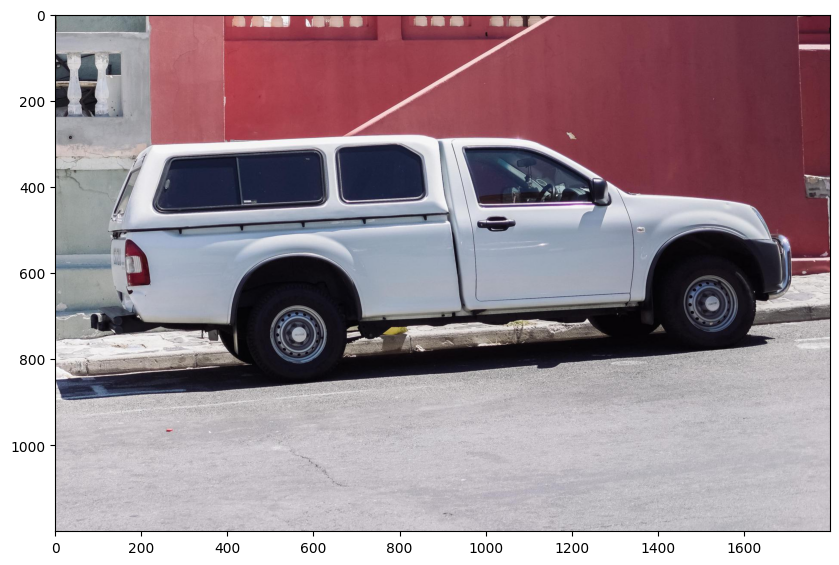

In [25]:
plt.figure(figsize=(10,10))
plt.imshow(image)
plt.axis('on')
plt.show()

In [26]:
import sys
sys.path.append("..")

sam_checkpoint = "sam_vit_b_01ec64.pth"
model_type = "vit_b"

device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

predictor = SamPredictor(sam)

In [27]:
predictor.set_image(image)

[to()] moving tensor from cuda:0 to cuda
[to()] moving tensor from cuda:0 to cuda
[to()] moving tensor from cuda:0 to cuda
[to()] moving tensor from cuda:0 to cuda
[to()] moving tensor from cuda:0 to cuda
[to()] moving tensor from cuda:0 to cuda
[to()] moving tensor from cuda:0 to cuda
[to()] moving tensor from cuda:0 to cuda
[to()] moving tensor from cuda:0 to cuda
[to()] moving tensor from cuda:0 to cuda
[to()] moving tensor from cuda:0 to cuda
[to()] moving tensor from cuda:0 to cuda
[to()] moving tensor from cuda:0 to cuda
[to()] moving tensor from cuda:0 to cuda
[to()] moving tensor from cuda:0 to cuda
[to()] moving tensor from cuda:0 to cuda
[to()] moving tensor from cuda:0 to cuda
[to()] moving tensor from cuda:0 to cuda
[to()] moving tensor from cuda:0 to cuda
[to()] moving tensor from cuda:0 to cuda
[to()] moving tensor from cuda:0 to cuda
[to()] moving tensor from cuda:0 to cuda
[to()] moving tensor from cuda:0 to cuda
[to()] moving tensor from cuda:0 to cuda
[to()] moving te

In [28]:
input_point = np.array([[500, 375]])
input_label = np.array([1])

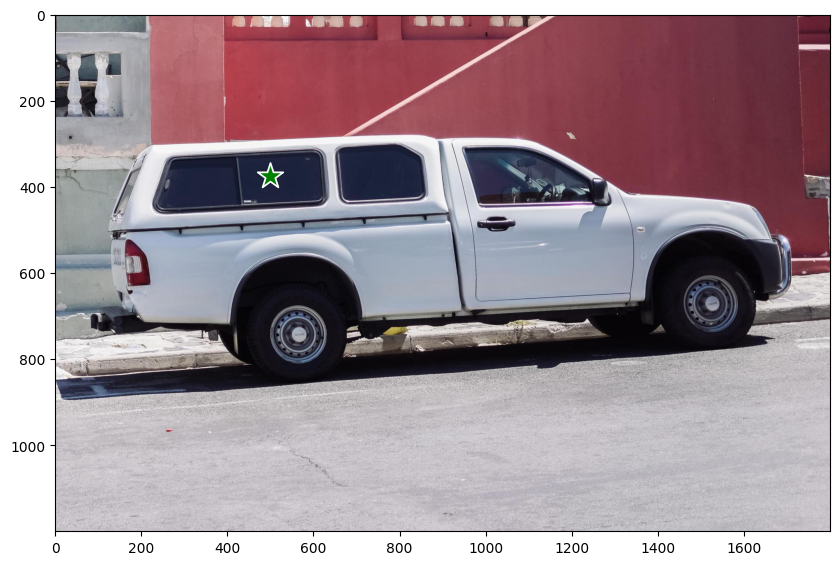

In [29]:
plt.figure(figsize=(10,10))
plt.imshow(image)
show_points(input_point, input_label, plt.gca())
plt.axis('on')
plt.show()

In [30]:
masks, scores, logits = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    multimask_output=True,
)
masks.shape  # (number_of_masks) x H x W


torch.Size([1, 2, 256]) torch.Size([1, 256, 64, 64])
torch.Size([1, 256, 64, 64])
torch.Size([1, 256, 64, 64])


(3, 1200, 1800)

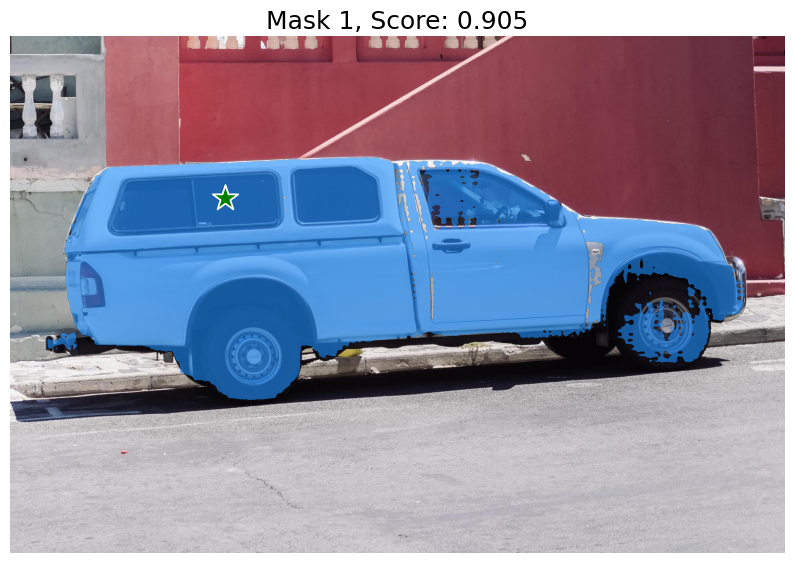

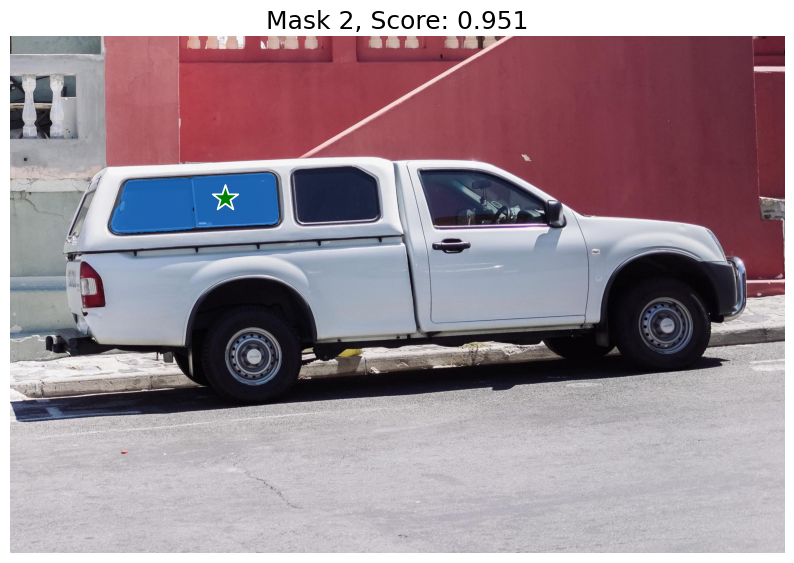

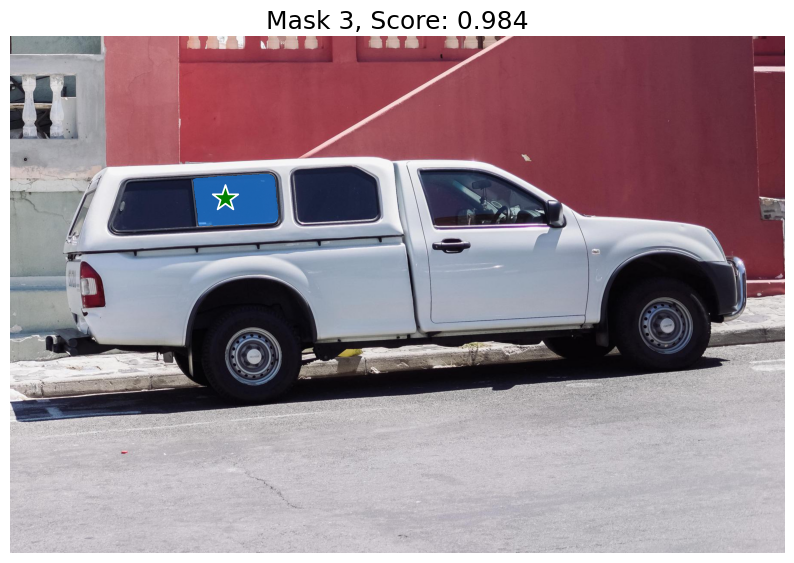

In [31]:
for i, (mask, score) in enumerate(zip(masks, scores)):
    plt.figure(figsize=(10,10))
    plt.imshow(image)
    show_mask(mask, plt.gca())
    show_points(input_point, input_label, plt.gca())
    plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
    plt.axis('off')
    plt.show()


In [32]:
image_encoder=ImageEncoderViT(
            depth=12,
            embed_dim=768,
            img_size=1024,
            mlp_ratio=4,
            norm_layer=partial(torch.nn.LayerNorm, eps=1e-6),
            num_heads=12,
            patch_size=16,
            qkv_bias=True,
            use_rel_pos=True,
            global_attn_indexes=[2, 5, 8, 11],
            window_size=14,
            out_chans=256,
        )

In [33]:

class DebugWrapper(nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model

    def forward(self, x):
        print(f"[INPUT] device: {x.device}")
        out = self.model(x)

        # Traverse output
        if isinstance(out, torch.Tensor):
            print(f"[OUTPUT] device: {out.device}")
        elif isinstance(out, (tuple, list)):
            for idx, o in enumerate(out):
                if isinstance(o, torch.Tensor):
                    print(f"[OUTPUT {idx}] device: {o.device}")
        return out


In [34]:
predictor.model.image_encoder = DebugWrapper(predictor.model.image_encoder)

# image_encoder = DebugWrapper(image_encoder)

In [35]:
image_encoder = predictor.model.image_encoder.eval().to("cuda")
example_input_encoder = torch.randn(1, 3, 1024, 1024).to("cuda")
script_model_encoder = torch.jit.script(image_encoder, example_input_encoder)

In [483]:
# Assume batch size = 1 and image embeddings of 256x64x64 (typical ViT features)
image_embeddings = torch.randn(1, 256, 64, 64).to("cuda")         # (B, C, H, W)
image_pe = torch.randn(1, 256, 64, 64).to("cuda")                 # same shape as image_embeddings

# Sparse prompts (e.g., points or boxes): (B, N_sparse, C)
sparse_prompt_embeddings = torch.randn(1, 4, 256).to("cuda")      # N_sparse=4 prompts

# Dense prompt (like mask): (B, C, H, W)
dense_prompt_embeddings = torch.randn(1, 256, 64, 64).to("cuda")  # same shape as image_embeddings

# Boolean value (not a tensor, pass as bool in scripting/tracing context)
multimask_output = True  # or False


In [484]:
class MaskDecoderWrapper(torch.nn.Module):
    def __init__(self, decoder):
        super().__init__()
        self.decoder = decoder

    def forward(self, image_embeddings, image_pe, sparse_prompt_embeddings, dense_prompt_embeddings):
        return self.decoder(image_embeddings, image_pe, sparse_prompt_embeddings, dense_prompt_embeddings)

mask_decoder = MaskDecoderWrapper(predictor.model.mask_decoder).eval().to("cuda")


In [ ]:
example_inputs_decoder = (
    image_embeddings,
    image_pe,
    sparse_prompt_embeddings,
    dense_prompt_embeddings
)

script_model_mask = torch.jit.trace(mask_decoder, example_inputs_decoder)

In [486]:
script_model_mask = torch.jit.trace(
    mask_decoder,
    example_inputs_decoder,
    check_inputs=[
        (
            torch.randn(1, 256, 32, 32).to("cuda"),
            torch.randn(1, 256, 32, 32).to("cuda"),
            torch.randn(1, 3, 256).to("cuda"),
            torch.randn(1, 256, 32, 32).to("cuda"),
        ),
        (
            torch.randn(1, 256, 128, 128).to("cuda"),
            torch.randn(1, 256, 128, 128).to("cuda"),
            torch.randn(1, 1, 256).to("cuda"),
            torch.randn(1, 256, 128, 128).to("cuda"),
        )
    ],
    strict=False
)

In [487]:
print(script_model_mask.graph)
print(script_model_mask.code)


graph(%self.1 : __torch__.___torch_mangle_7291.MaskDecoderWrapper,
      %image_embeddings : Float(1, 256, 64, 64, strides=[1048576, 4096, 64, 1], requires_grad=0, device=cuda:0),
      %image_pe.1 : Float(1, 256, 64, 64, strides=[1048576, 4096, 64, 1], requires_grad=0, device=cuda:0),
      %sparse_prompt_embeddings : Float(1, 4, 256, strides=[1024, 256, 1], requires_grad=0, device=cuda:0),
      %dense_prompt_embeddings.1 : Float(1, 256, 64, 64, strides=[1048576, 4096, 64, 1], requires_grad=0, device=cuda:0)):
  %decoder : __torch__.___torch_mangle_7290.MaskDecoder = prim::GetAttr[name="decoder"](%self.1)
  %2043 : (Tensor, Tensor) = prim::CallMethod[name="forward"](%decoder, %sparse_prompt_embeddings, %image_pe.1, %dense_prompt_embeddings.1, %image_embeddings)
  %2041 : Float(1, 3, 256, 256, strides=[262144, 65536, 256, 1], requires_grad=1, device=cuda:0), %2042 : Float(1, 3, strides=[4, 1], requires_grad=1, device=cuda:0) = prim::TupleUnpack(%2043)
  %1633 : (Float(1, 3, 256, 256, 

In [488]:
for name, param in predictor.model.image_encoder.named_parameters():
    print(f"[PARAM] {name} device: {param.device}")

for name, buffer in predictor.model.image_encoder.named_buffers():
    print(f"[BUFFER] {name} device: {buffer.device}")


[PARAM] pos_embed device: cuda:0
[PARAM] patch_embed.proj.weight device: cuda:0
[PARAM] patch_embed.proj.bias device: cuda:0
[PARAM] blocks.0.norm1.weight device: cuda:0
[PARAM] blocks.0.norm1.bias device: cuda:0
[PARAM] blocks.0.attn.rel_pos_h device: cuda:0
[PARAM] blocks.0.attn.rel_pos_w device: cuda:0
[PARAM] blocks.0.attn.qkv.weight device: cuda:0
[PARAM] blocks.0.attn.qkv.bias device: cuda:0
[PARAM] blocks.0.attn.proj.weight device: cuda:0
[PARAM] blocks.0.attn.proj.bias device: cuda:0
[PARAM] blocks.0.norm2.weight device: cuda:0
[PARAM] blocks.0.norm2.bias device: cuda:0
[PARAM] blocks.0.mlp.lin1.weight device: cuda:0
[PARAM] blocks.0.mlp.lin1.bias device: cuda:0
[PARAM] blocks.0.mlp.lin2.weight device: cuda:0
[PARAM] blocks.0.mlp.lin2.bias device: cuda:0
[PARAM] blocks.1.norm1.weight device: cuda:0
[PARAM] blocks.1.norm1.bias device: cuda:0
[PARAM] blocks.1.attn.rel_pos_h device: cuda:0
[PARAM] blocks.1.attn.rel_pos_w device: cuda:0
[PARAM] blocks.1.attn.qkv.weight device: cuda

In [492]:
# Run JIT model to verify shape logic before TRT
with torch.no_grad():
    out = script_model_mask(*example_inputs_decoder)
    print("Output OK:", out[0].shape if isinstance(out, tuple) else out.shape)

Output OK: torch.Size([1, 3, 256, 256])


In [85]:
os.environ["TORCH_TENSORRT_LOG_LEVEL"] = "DEBUG"   # for torch-tensorrt logs
os.environ["TRT_LOGGER_SEVERITY"] = "VERBOSE"       # for TensorRT backend logs

In [86]:
def print_device(x, tag=""):
    if isinstance(x, torch.Tensor):
        print(f"[{tag}] device:", x.device)

with torch.no_grad():
    outputs = image_encoder(example_input)
    print_device(outputs, "Output")


[INPUT] device: cuda:0
[to()] moving tensor from cuda:0 to cuda
[to()] moving tensor from cuda:0 to cuda
[to()] moving tensor from cuda:0 to cuda
[to()] moving tensor from cuda:0 to cuda
[to()] moving tensor from cuda:0 to cuda
[to()] moving tensor from cuda:0 to cuda
[to()] moving tensor from cuda:0 to cuda
[to()] moving tensor from cuda:0 to cuda
[to()] moving tensor from cuda:0 to cuda
[to()] moving tensor from cuda:0 to cuda
[to()] moving tensor from cuda:0 to cuda
[to()] moving tensor from cuda:0 to cuda
[to()] moving tensor from cuda:0 to cuda
[to()] moving tensor from cuda:0 to cuda
[to()] moving tensor from cuda:0 to cuda
[to()] moving tensor from cuda:0 to cuda
[to()] moving tensor from cuda:0 to cuda
[to()] moving tensor from cuda:0 to cuda
[to()] moving tensor from cuda:0 to cuda
[to()] moving tensor from cuda:0 to cuda
[to()] moving tensor from cuda:0 to cuda
[to()] moving tensor from cuda:0 to cuda
[to()] moving tensor from cuda:0 to cuda
[to()] moving tensor from cuda:0 t

In [36]:
trt_model_encoder = torch_tensorrt.compile(
    script_model_encoder,
    inputs=[
        torch_tensorrt.Input(
            # (1, 3, 1024, 1024),
            min_shape=(1, 3, 1024, 1024), opt_shape=(1, 3, 1024, 1024), max_shape=(1, 3, 1024, 1024),
            dtype=torch.float  # or torch.float
        )
    ],
    enabled_precisions={torch.float},
    truncate_long_and_double=True
)


Input is a torchscript module but the ir was not specified (default=dynamo), please set ir=torchscript to suppress the warning.


RuntimeError: 0 INTERNAL ASSERT FAILED at "/pytorch/torch/csrc/jit/ir/alias_analysis.cpp":616, please report a bug to PyTorch. We don't have an op for aten::floor_divide but it isn't a special case.  Argument types: int, int, 

Candidates:
	aten::floor_divide(Tensor self, Tensor other) -> Tensor
	aten::floor_divide.Scalar(Tensor self, Scalar other) -> Tensor
	aten::floor_divide.out(Tensor self, Tensor other, *, Tensor(a!) out) -> Tensor(a!)
	aten::floor_divide.Scalar_out(Tensor self, Scalar other, *, Tensor(a!) out) -> Tensor(a!)

In [491]:
# Define input shapes (adjust to match your model)
B, C, H, W = 1, 256, 64, 64
NUM_SPARSE_TOKENS = 2
NUM_DENSE_TOKENS = B * 1  # e.g., per image

example_inputs = [
    torch.randn(B, C, H, W).to("cuda"),              # image_embeddings
    torch.randn(B, C, H, W).to("cuda"),              # image_pe
    torch.randn(B, NUM_SPARSE_TOKENS, C).to("cuda"), # sparse_prompt_embeddings
    torch.randn(NUM_DENSE_TOKENS, C, H, W).to("cuda"), # dense_prompt_embeddings
    # torch.tensor(True).to("cuda")                    # multimask_output (bool)
]


trt_model_decoder = torch_tensorrt.compile(
    script_model_mask,
    inputs=[
        torch_tensorrt.Input(example_inputs[0].shape, dtype=torch.float),
        torch_tensorrt.Input(example_inputs[1].shape, dtype=torch.float),
        torch_tensorrt.Input(min_shape=(1, 1, 256), opt_shape=(1, 2, 256), max_shape=(1, 2, 256), dtype=torch.float),
        torch_tensorrt.Input(example_inputs[3].shape, dtype=torch.float),
        # torch_tensorrt.Input(example_inputs[4].shape, dtype=torch.bool),
    ],
    enabled_precisions={torch.float},  # or {torch.half} if your model supports fp16
    truncate_long_and_double=True,
    allow_shape_tensors=True
)

Input is a torchscript module but the ir was not specified (default=dynamo), please set ir=torchscript to suppress the warning.


RuntimeError: [Error thrown at core/conversion/converters/converter_util.cpp:467] The expanded size of the tensor (-1) isn't allowed in a leading, non-existing dimension 1


In [ ]:
# # Constants
# B = 1
# C = 256
# NUM_SPARSE_TOKENS = 4
# H_min, H_opt, H_max = 16, 64, 64   # image features: H,W = input_size / 16 → 256 → 16, 1024 → 64
# W_min, W_opt, W_max = 16, 64, 64

# trt_model_decoder = torch_tensorrt.compile(
#     script_model_mask,
#     inputs=[
#         torch_tensorrt.Input(
#             min_shape=(B, C, H_min, W_min),
#             opt_shape=(B, C, H_opt, W_opt),
#             max_shape=(B, C, H_max, W_max),
#             dtype=torch.float,
#         ),  # image_embeddings

#         torch_tensorrt.Input(
#             min_shape=(B, C, H_min, W_min),
#             opt_shape=(B, C, H_opt, W_opt),
#             max_shape=(B, C, H_max, W_max),
#             dtype=torch.float,
#         ),  # image_pe

#         torch_tensorrt.Input(
#             min_shape=(B, NUM_SPARSE_TOKENS, C),
#             opt_shape=(B, NUM_SPARSE_TOKENS, C),
#             max_shape=(B, NUM_SPARSE_TOKENS, C),
#             dtype=torch.float,
#         ),  # sparse_prompt_embeddings

#         torch_tensorrt.Input(
#             min_shape=(B, C, H_min, W_min),
#             opt_shape=(B, C, H_opt, W_opt),
#             max_shape=(B, C, H_max, W_max),
#             dtype=torch.float,
#         ),  # dense_prompt_embeddings
#     ],
#     enabled_precisions={torch.float},  # or {torch.half}
#     truncate_long_and_double=True,
# )


Input is a torchscript module but the ir was not specified (default=dynamo), please set ir=torchscript to suppress the warning.


The compiler is going to use the user setting Float
This conflict may cause an error at runtime due to partial compilation being enabled and therefore
compatibility with PyTorch's data type convention is required.
If you do indeed see errors at runtime either:
- Remove the dtype spec for image_pe.1
- Disable partial compilation by setting require_full_compilation to True


RuntimeError: [Error thrown at core/conversion/converters/converter_util.cpp:467] The expanded size of the tensor (-1) isn't allowed in a leading, non-existing dimension 1


In [ ]:
input_data = torch.randn(1, 3, 1024, 1024).to("cuda")

with torch.no_grad():
    output = trt_model_encoder(input_data)
    print("Output shape:", output.shape)
    print("Output device:", output.device)

Output shape: torch.Size([1, 256, 64, 64])
Output device: cuda:0


In [330]:
outputs = trt_model_decoder(
    image_embeddings,
    image_pe,
    sparse_prompt_embeddings,
    dense_prompt_embeddings
)

In [213]:
# Save the TRT model (it's a TorchScript ScriptModule)
trt_model_encoder.save("image_encoder_trt.ts")

trt_model_decoder.save("mask_decoder_trt.ts")

In [ ]:
# ✅ Input: correct shape, device, and dtype
input_tensor = torch.randn(1, 3, 1024, 1024).to("cuda").to(torch.float32)

# ✅ Make sure the model is on CUDA too (though TensorRT models are usually already)
trt_model = trt_model_encoder.to("cuda")  # Optional for TRT

# ✅ Inference
with torch.no_grad():
    output = trt_model(input_tensor)

print("Output shape:", output.shape)


Output shape: torch.Size([1, 256, 64, 64])


In [91]:
print("Is input on CUDA?", input_data.is_cuda)  # Should be True
print("Input dtype:", input_data.dtype)         # Should match compilation dtype

Is input on CUDA? True
Input dtype: torch.float32


In [92]:
print(trt_model)  # If it's TorchScript, check manually
print("Is input CUDA:", input_tensor.is_cuda)
print("TRT model type:", type(trt_model))
# print("TRT model graph input:", trt_model.graph)

@torch.jit.script
def debug_device(x):
    print("Inside model, x device:", x.device)
    return x

debug_device(torch.randn(1, 3, 224, 224).to("cuda"))

RecursiveScriptModule(original_name=DebugWrapper_trt)
Is input CUDA: True
TRT model type: <class 'torch.jit._script.RecursiveScriptModule'>
Inside model, x device: cuda:0


tensor([[[[-5.4826e-01, -1.3655e+00,  6.4287e-01,  ..., -3.6588e-01,
            1.2066e+00, -1.7456e+00],
          [-2.0685e+00, -2.5534e+00,  6.7354e-02,  ..., -1.8693e-01,
           -1.1903e-01,  1.2550e+00],
          [-9.6918e-02, -8.0464e-01,  5.6976e-01,  ..., -9.1885e-02,
            5.1394e-01,  6.4730e-01],
          ...,
          [ 3.0906e-01, -5.3964e-02,  1.2582e+00,  ...,  1.1914e+00,
            1.6913e+00, -3.7655e-01],
          [-7.5968e-01, -3.8327e-01,  7.0504e-01,  ...,  3.2399e-01,
            1.9156e-01,  3.8876e-01],
          [ 6.4948e-01,  5.8525e-01,  2.9909e-01,  ...,  4.4359e-02,
            1.4668e+00, -9.1125e-01]],

         [[-1.1329e+00,  2.5273e+00,  1.6164e+00,  ...,  8.6892e-01,
            1.1391e+00,  5.7714e-01],
          [ 1.3885e+00, -6.4661e-01,  6.1080e-02,  ...,  1.0347e+00,
            1.0063e+00, -7.4326e-01],
          [ 9.4688e-02,  1.8614e-01,  3.4129e-01,  ..., -1.1918e+00,
            1.1344e+00,  1.1554e+00],
          ...,
     

In [93]:
print("TRT model type:", type(trt_model))
print("TRT model is CUDA:", trt_model.is_cuda() if hasattr(trt_model, 'is_cuda') else "unknown")


TRT model type: <class 'torch.jit._script.RecursiveScriptModule'>
TRT model is CUDA: unknown


In [39]:
# Example input
example_input = torch.randn(1, 3, 1024, 1024).to("cuda")

# Move model to CUDA and eval mode
model = predictor.model.image_encoder.to("cuda").eval()

# Export to ONNX
torch.onnx.export(
    model,                      # PyTorch model
    example_input,              # example input
    "image_encoder.onnx",       # output filename
    export_params=True,         # store trained weights
    opset_version=17,           # ONNX opset version
    do_constant_folding=True,   # optimize constants
    input_names=['input'],      # input tensor name
    output_names=['output'],    # output tensor name
    dynamic_axes={              # for variable size inputs
        'input': {0: 'batch_size'},
        'output': {0: 'batch_size'}
    }
)

  if pad_h > 0 or pad_w > 0:

  pad_height = torch.floor_divide(torch.tensor(Hp), torch.tensor(window_size))

  pad_height = torch.floor_divide(torch.tensor(Hp), torch.tensor(window_size))

  pad_weight = torch.floor_divide(torch.tensor(Wp), torch.tensor(window_size))

  pad_weight = torch.floor_divide(torch.tensor(Wp), torch.tensor(window_size))

  max_rel_dist = int(2 * max(q_size, k_size) - 1)

  max_rel_dist = int(2 * max(q_size, k_size) - 1)

  if rel_pos.shape[0] != max_rel_dist:

  q_coords = torch.arange(q_size, device="cuda")[:, None] * max(k_size / q_size, 1.0)

  k_coords = torch.arange(k_size, device="cuda")[None, :] * max(q_size / k_size, 1.0)

  relative_coords = (q_coords - k_coords) + (k_size - 1) * max(q_size / k_size, 1.0)

  B = torch.floor_divide(torch.tensor(windows.shape[0]), torch.floor_divide(torch.tensor(Hp * Wp), torch.tensor(window_size * window_size)))

  B = torch.floor_divide(torch.tensor(windows.shape[0]), torch.floor_divide(torch.tensor(Hp * Wp), torch.t

In [38]:
!pip install onnx

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.6/17.6 MB 81.0 MB/s eta 0:00:00


In [42]:
import onnxruntime as ort

# Load ONNX model
ort_session = ort.InferenceSession("image_encoder.onnx")

# Prepare input
onnx_input = example_input.cpu().numpy()

# Run inference
outputs = ort_session.run(None, {"input": onnx_input})
print("ONNX Output Shape:", outputs[0].shape)

ONNX Output Shape: (1, 256, 64, 64)


In [45]:
!pip uninstall onnxruntime
!pip install onnxruntime-gpu

Found existing installation: onnxruntime 1.22.1
Uninstalling onnxruntime-1.22.1:
  Would remove:
    /usr/local/bin/onnxruntime_test
    /usr/local/lib/python3.11/dist-packages/onnxruntime-1.22.1.dist-info/*
    /usr/local/lib/python3.11/dist-packages/onnxruntime/*
Proceed (Y/n)? y
  Successfully uninstalled onnxruntime-1.22.1
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 283.2/283.2 MB 792.6 kB/s eta 0:00:00


In [43]:
import time

# Warm-up
input_tensor = torch.randn(1, 3, 1024, 1024).to("cuda")
model = predictor.model.image_encoder.to("cuda").eval()
with torch.no_grad():
    _ = model(input_tensor)  # Warm-up

# Measure
start = time.time()
with torch.no_grad():
    for _ in range(10):  # Run multiple times for better averaging
        _ = model(input_tensor)
end = time.time()

print(f"PyTorch avg time: {(end - start) / 10:.4f} seconds")

PyTorch avg time: 0.3505 seconds


In [ ]:
import time

# ✅ Input: correct shape, device, and dtype
input_tensor = torch.randn(1, 3, 1024, 1024).to("cuda").to(torch.float32)


# ✅ Make sure the model is on CUDA too (though TensorRT models are usually already)
trt_model = trt_model.to("cuda")  # Optional for TRT

# Warm-up
with torch.no_grad():  
        _ = trt_model(input_tensor)

# Measure
start = time.time()
with torch.no_grad():
    for _ in range(10):    
        _ = trt_model(input_tensor)
end = time.time()

print(f"Tensorrt avg time: {(end - start) / 10:.4f} seconds")


Tensorrt avg time: 0.0281 seconds


In [368]:
import time

# Example dummy inputs with correct shapes and on CUDA
image_embeddings = torch.randn(1, 256, 64, 64).to("cuda").to(torch.float32)
image_pe = torch.randn(1, 256, 64, 64).to("cuda").to(torch.float32)
sparse_prompt_embeddings = torch.randn(1, 4, 256).to("cuda").to(torch.float32)
dense_prompt_embeddings = torch.randn(1, 256, 64, 64).to("cuda").to(torch.float32)

# Warm-up
with torch.no_grad():
    _ = trt_model(
        image_embeddings,
        image_pe,
        sparse_prompt_embeddings,
        dense_prompt_embeddings
    )

# Measure
start = time.time()
with torch.no_grad():
    for _ in range(100):
        _ = trt_model(
            image_embeddings,
            image_pe,
            sparse_prompt_embeddings,
            dense_prompt_embeddings
        )
end = time.time()

print(f"Mask Decoder TRT avg time: {(end - start) / 1:.4f} seconds")


Mask Decoder TRT avg time: 0.0665 seconds


In [370]:
class OptimizedImageEncoder(torch.nn.Module):
    def __init__(self, trt_module):
        super().__init__()
        self.trt = trt_module

    def forward(self, x):
        return self.trt(x)
    
class OptimizedMaskDecoder(torch.nn.Module):
    def __init__(self, trt_module):
        super().__init__()
        self.trt = trt_module

    def forward(self, image_embeddings, image_pe, sparse_prompt_embeddings, dense_prompt_embeddings):
        # Adjust this if your compiled TRT model needs additional or fewer inputs
        return self.trt(image_embeddings, image_pe, sparse_prompt_embeddings, dense_prompt_embeddings)

In [371]:
import sys
sys.path.append("..")

sam_checkpoint = "sam_vit_b_01ec64.pth"
model_type = "vit_b"

device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

predictor = SamPredictor(sam)

In [372]:
original_encoder = sam.image_encoder  # save before replacing

In [373]:


sam.image_encoder = OptimizedImageEncoder(trt_model_encoder)
sam.image_encoder.img_size = original_encoder.img_size

sam.mask_decoder = OptimizedMaskDecoder(trt_model_decoder)

In [374]:
predictor = SamPredictor(sam)

In [375]:
predictor.set_image(image)

In [376]:
(predictor.get_image_embedding()).shape

torch.Size([1, 256, 64, 64])

In [ ]:
masks, scores, logits = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    multimask_output=True,
)
masks.shape  # (number_of_masks) x H x W


torch.Size([1, 2, 256]) torch.Size([1, 256, 64, 64])
torch.Size([1, 256, 64, 64])
torch.Size([1, 256, 64, 64])


(3, 1200, 1800)

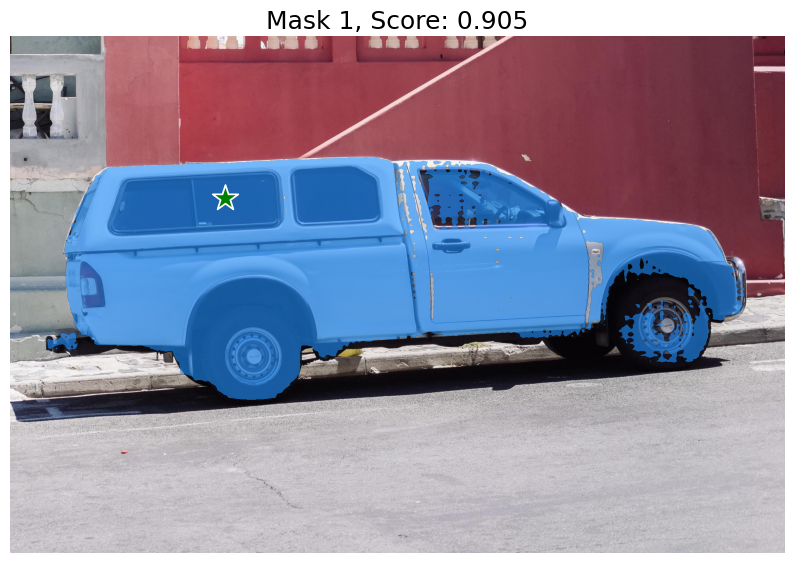

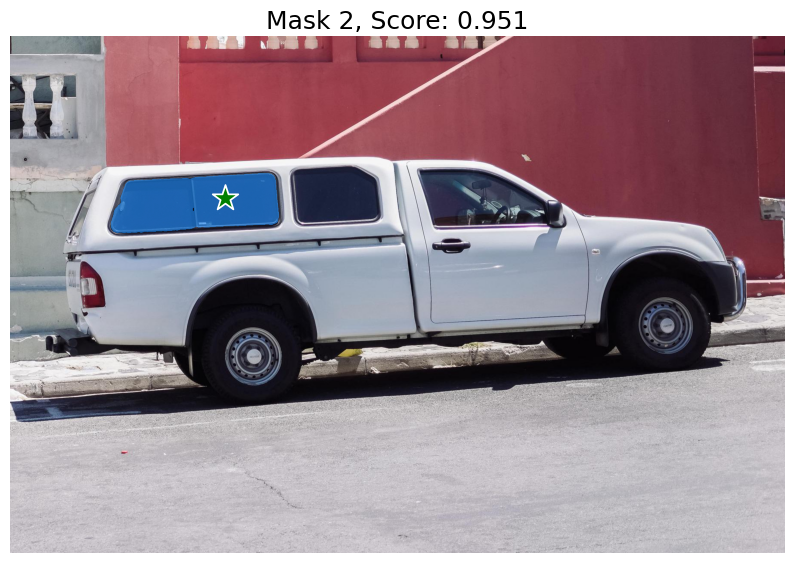

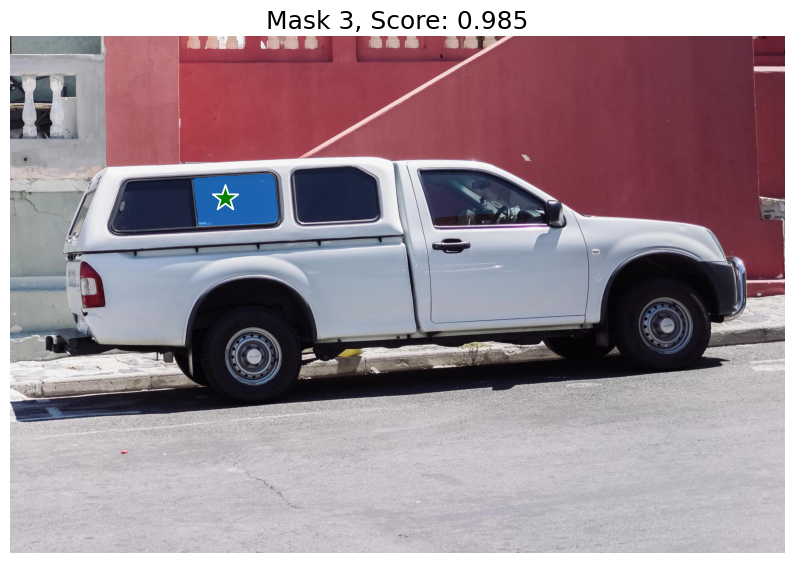

In [378]:
for i, (mask, score) in enumerate(zip(masks, scores)):
    plt.figure(figsize=(10,10))
    plt.imshow(image)
    show_mask(mask, plt.gca())
    show_points(input_point, input_label, plt.gca())
    plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
    plt.axis('off')
    plt.show()
